In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import math
import numpy as np
import copy
import time
import pickle
from random import seed, shuffle, sample

from sklearn.preprocessing import StandardScaler
from aif360.datasets import AdultDataset, CompasDataset, GermanDataset, BankDataset, StandardDataset

import matplotlib
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [2]:
sys.path.append('../baselines/iFair/')
sys.path.append('../baselines/LFR/')
sys.path.append('../baselines/PFR/')
sys.path.append('../iFlipper/')

from iflipper import iFlipper
from aif360.algorithms.preprocessing import LFR
from iFair import iFair
from PFR import PFR, similarity_pfr, estimate_dim

from cplex_solver import CPLEX_Solver
from greedy import Greedy
from gradient import Gradient
from kmeans import kMeans

from utils import measure_error, generate_sim_matrix
from model import Model

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


# Load fairness dataset from AIF360 and define variables
### 1. Dataset = COMPAS, AdultCensus, Credit
### 2. Similarity matrix = knn, threshold
### 3. ML model = LogisticRegression, RandomForest, NeuralNetwork

In [ ]:
dataset_type = "AdultCensus" # AdultCensus, Credit COMPAS
similarity_matrix = "knn" # threshold
model_type = "LogisticRegression" # RandomForest, NeuralNetwork

PRINT_RESULT = 1

In [ ]:
similarity_params = dict()

if dataset_type == "COMPAS":
    dataset = CompasDataset(label_name='two_year_recid', favorable_classes=[0], 
                            protected_attribute_names=['sex'], privileged_classes=[['Female']], 
                            categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc', 'race'], 
                            features_to_keep=['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'two_year_recid'], 
                            features_to_drop=[], na_values=[])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1
    
    similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 1, 10, 0.05
    similarity_params["k"], similarity_params["threshold"] = 20, 3

    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.001, 0]
    
elif dataset_type == "AdultCensus":
    dataset = AdultDataset(label_name='income-per-year', favorable_classes=['>50K', '>50K.'], 
                    protected_attribute_names=['sex'], privileged_classes=[['Male']], 
                    categorical_features=['race', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'], 
                    features_to_keep=[], features_to_drop=['fnlwgt'], na_values=['?'])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1

    similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 10, 50, 0.1
    similarity_params["k"], similarity_params["threshold"]  = 20, 3

    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 0]
    
elif dataset_type == "Credit":
    def label_processing(df):
        credit_map = {1.0 : 1.0, 2.0 : 0.0}
        status_map = {'A91': 'male', 'A93': 'male', 'A94': 'male',
                      'A92': 'female', 'A95': 'female'}
        df['credit'] = df['credit'].replace(credit_map)
        df['sex'] = df['personal_status'].replace(status_map)    
        return df
    
    dataset = GermanDataset(custom_preprocessing = label_processing, 
                            metadata={'label_maps': [{1.0: 'Good Credit', 0.0: 'Bad Credit'}], 'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, {1.0: 'Old', 0.0: 'Young'}]})
    protected = "age"
    num_train, num_test, num_val = 0.7, 0.2, 0.1

    similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 1, 10, 0.05
    similarity_params["k"], similarity_params["threshold"]  = 20, 7
    
    num_plot = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]

privileged_groups = [{protected: 1}]
unprivileged_groups = [{protected: 0}]

In [ ]:
scaler = StandardScaler()
train, test, val = dataset.split([num_train, num_train+num_test], shuffle=True, seed=0)

train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)
val.features = scaler.fit_transform(val.features)
index = train.feature_names.index(protected)

# remove sensitive features
x_train = np.delete(train.features, index, axis=1)
x_test = np.delete(test.features, index, axis=1)
x_val = np.delete(val.features, index, axis=1)

y_train = train.labels.ravel()
y_test = test.labels.ravel()
y_val = val.labels.ravel()

# keep sensitive column for PFR
train_sensitive = np.reshape(train.features[:, index], (-1, 1))
test_sensitive = np.reshape(test.features[:, index], (-1, 1))
val_sensitive = np.reshape(val.features[:, index], (-1, 1))

# For iFair
x_train_with_sensitive = np.concatenate((x_train, train_sensitive), axis = 1)
x_test_with_sensitive = np.concatenate((x_test, test_sensitive), axis = 1)
x_val_with_sensitive = np.concatenate((x_val, val_sensitive), axis = 1)

print("Dataset: %s" % dataset_type)
print("Number of training data: %d, Number of test data: %d, Number of validation data: %d\n" % (x_train.shape[0], x_test.shape[0], x_val.shape[0]))

Dataset: AdultCensus
Number of training data: 27133, Number of test data: 13566, Number of validation data: 4523



# Obtain similarity matrix

In [ ]:
w_train, edge_train, w_edge_train = generate_sim_matrix(x_train, similarity_matrix, similarity_params)
w_test, edge_test, w_edge_test = generate_sim_matrix(x_test, similarity_matrix, similarity_params)
w_val, edge_val, w_edge_val = generate_sim_matrix(x_val, similarity_matrix, similarity_params)

# Original result (without any pre-processing)

In [ ]:
test_accuracy, test_consistency_score, runtime = dict(), dict(), dict()

model = Model(model_type, x_train, y_train, edge_train, w_edge_train, x_test, y_test, edge_test, w_edge_test, x_val, y_val)
train_performance, test_performance = model.train()

test_accuracy["Original"], test_consistency_score["Original"] = [test_performance[0]], [test_performance[1]]
print(f"Test Accuracy: {test_performance[0]:.5f}")
print(f"Test Consistency Score: {test_performance[1]:.5f}")

Test Accuracy: 0.85007
Test Consistency Score: 0.92993


# iFlipper on different total error limits (m)

In [ ]:
method = "iFlipper"
test_accuracy[method], test_consistency_score[method], runtime[method] = [], [], []

init_error = measure_error(y_train, edge_train, w_edge_train)
print(f"Initial amount of total error: {init_error:.1f}")

for i in num_plot:
    m = (init_error * i)
        
    start = time.time()
    IFLIP = iFlipper(y_train, w_train, edge_train, w_edge_train)
    flipped_label = IFLIP.transform(m)
    elapsed_time = time.time() - start

    model = Model(model_type, x_train, flipped_label, edge_train, w_edge_train, x_test, y_test, edge_test, w_edge_test, x_val, y_val)
    train_performance, test_performance = model.train()

    test_accuracy[method].append(test_performance[0])
    test_consistency_score[method].append(test_performance[1])
    runtime[method].append(elapsed_time)
    
    if PRINT_RESULT:
        print("============================")
        print(f"Total error limit: {m:.1f}")
        print(f"Total error: {measure_error(flipped_label, edge_train, w_edge_train):.1f}")
        print(f"Number of flips: {np.sum(y_train != flipped_label)}")
        print(f"Test Accuracy: {test_performance[0]:.5f}") 
        print(f"Test Consistency Score: {test_performance[1]:.5f}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Initial amount of total error: 65742.5
Total error limit: 65742.5
Total error: 65742.5
Number of flips: 0
Test Accuracy: 0.85007
Test Consistency Score: 0.92993
Runtime (sec): 0.00397
Total error limit: 52594.0
Total error: 52591.5
Number of flips: 601
Test Accuracy: 0.85029
Test Consistency Score: 0.93271
Runtime (sec): 282.24049
Total error limit: 39445.5
Total error: 39443.8
Number of flips: 1390
Test Accuracy: 0.84940
Test Consistency Score: 0.93927
Runtime (sec): 278.45016
Total error limit: 26297.0
Total error: 26287.0
Number of flips: 2320
Test Accuracy: 0.84410
Test Consistency Score: 0.95036
Runtime (sec): 277.65736
Total error limit: 13148.5
Total error: 13147.5
Number of flips: 3404
Test Accuracy: 0.83768
Test Consistency Score: 0.95850
Runtime (sec): 315.73108
Total error limit: 6574.3
Total error: 6567.8
Number of flips: 4123
Test Accuracy: 0.83053
Test Consistency Score: 0.96655
Runtime (sec): 267.68468
Total error limit: 3287.1
Total error: 3285.5
Number of flips: 4597
T

# LFR (Learning Fair Representations, ICML 2013)
## Implemented in AIF360 toolkit

In [ ]:
IMPORT_RESULT = True

method = "LFR"
test_accuracy[method], test_consistency_score[method], runtime[method] = [], [], []

if IMPORT_RESULT:
    with open(f'../baselines/LFR/{method}_{dataset_type}_{num_train}.pkl', 'rb') as f:
        save_dict = pickle.load(f)
        
    grid = len(save_dict["Ax"])
    for i in range(grid):
        TR = save_dict["TR"][i]
        Ax = save_dict["Ax"][i]
        Ay = save_dict["Ay"][i]
        Az = save_dict["Az"][i]
        elapsed_time = save_dict["elapsed_time"][i]
        
        start = time.time()
        transf_train = TR.transform(train)
        transf_test = TR.transform(test)
        transf_val = TR.transform(val)

        transf_x_train = np.delete(transf_train.features, index, axis=1)
        transf_x_test = np.delete(transf_test.features, index, axis=1)
        transf_x_val = np.delete(transf_val.features, index, axis=1)
        elapsed_time = (time.time() - start) + elapsed_time

        model = Model(model_type, transf_x_train, y_train, edge_train, w_edge_train, transf_x_test, y_test, edge_test, w_edge_test, transf_x_val, y_val)
        train_performance, test_performance = model.train()

        test_accuracy[method].append(test_performance[0])
        test_consistency_score[method].append(test_performance[1])
        runtime[method].append(elapsed_time)

        if PRINT_RESULT:
            print("============================")
            print(f"Ax:{Ax}, Ay:{Ay}, Az:{Az}")
            print(f"Test Accuracy: {test_performance[0]:.5f}") 
            print(f"Test Consistency Score: {test_performance[1]:.5f}")
            print(f"Runtime (sec): {elapsed_time:.5f}")
else:
    for Ax in [0.01]:
        for Ay in [0.1, 0.5, 1, 5]:
            for Az in [0, 0.1, 0.5, 1, 5]:
                start = time.time()
                TR = LFR(unprivileged_groups=unprivileged_groups,
                            privileged_groups=privileged_groups,
                            Ax=Ax, Ay=Ay, Az=Az,
                            verbose=0)
                TR = TR.fit(train)

                transf_train = TR.transform(train)
                transf_test = TR.transform(test)
                transf_val = TR.transform(val)

                transf_x_train = np.delete(transf_train.features, index, axis=1)
                transf_x_test = np.delete(transf_test.features, index, axis=1)
                transf_x_val = np.delete(transf_val.features, index, axis=1)
                elapsed_time = (time.time() - start)

                model = Model(model_type, transf_x_train, y_train, edge_train, w_edge_train, transf_x_test, y_test, edge_test, w_edge_test, transf_x_val, y_val)
                train_performance, test_performance = model.train()

                test_accuracy[method].append(test_performance[0])
                test_consistency_score[method].append(test_performance[1])
                runtime[method].append(elapsed_time)

                if PRINT_RESULT:
                    print("============================")
                    print(f"Ax:{Ax}, Ay:{Ay}, Az:{Az}")
                    print(f"Test Accuracy: {test_performance[0]:.5f}") 
                    print(f"Test Consistency Score: {test_performance[1]:.5f}")
                    print(f"Runtime (sec): {elapsed_time:.5f}")

Ax:0.01, Ay:0.1, Az:0
Test Accuracy: 0.80827
Test Consistency Score: 0.95559
Runtime (sec): 707.32137
Ax:0.01, Ay:0.1, Az:0.1
Test Accuracy: 0.79014
Test Consistency Score: 0.96356
Runtime (sec): 703.42785
Ax:0.01, Ay:0.1, Az:0.5
Test Accuracy: 0.82235
Test Consistency Score: 0.95077
Runtime (sec): 701.52388
Ax:0.01, Ay:0.1, Az:1
Test Accuracy: 0.78734
Test Consistency Score: 0.96526
Runtime (sec): 708.71041
Ax:0.01, Ay:0.1, Az:5
Test Accuracy: 0.80621
Test Consistency Score: 0.96459
Runtime (sec): 708.50006
Ax:0.01, Ay:0.5, Az:0
Test Accuracy: 0.80414
Test Consistency Score: 0.95662
Runtime (sec): 701.42888
Ax:0.01, Ay:0.5, Az:0.1
Test Accuracy: 0.80525
Test Consistency Score: 0.94325
Runtime (sec): 693.46718
Ax:0.01, Ay:0.5, Az:0.5
Test Accuracy: 0.78778
Test Consistency Score: 0.94482
Runtime (sec): 698.26308
Ax:0.01, Ay:0.5, Az:1
Test Accuracy: 0.80724
Test Consistency Score: 0.95592
Runtime (sec): 702.68917
Ax:0.01, Ay:0.5, Az:5
Test Accuracy: 0.81476
Test Consistency Score: 0.952

# iFair (Learning individually fair data representations for algorithmic decision making, ICDE 2019)
## https://github.com/plahoti-lgtm/iFair

In [ ]:
IMPORT_RESULT = True

method = "iFair"
test_accuracy[method], test_consistency_score[method], runtime[method] = [], [], []

save_name = f'../baselines/iFair/{method}_{dataset_type}_{num_train}.pkl'
if IMPORT_RESULT:
    with open(save_name, 'rb') as f:
        save_dict = pickle.load(f)

    grid = len(save_dict["Ax"])
    for i in range(grid):
        iF = save_dict["iF"][i]
        Ax = save_dict["Ax"][i]
        Az = save_dict["Az"][i]
        k = save_dict["k"][i]
        elapsed_time = save_dict["elapsed_time"][i]
        
        start = time.time()
        transf_x_train = iF.transform(x_train_with_sensitive)
        transf_x_test = iF.transform(x_test_with_sensitive)
        transf_x_val = iF.transform(x_val_with_sensitive)

        transf_x_train = np.delete(transf_x_train, -1, axis=1)
        transf_x_test = np.delete(transf_x_test, -1, axis=1)
        transf_x_val = np.delete(transf_x_val, -1, axis=1)
        elapsed_time = (time.time() - start) + elapsed_time

        model = Model(model_type, transf_x_train, y_train, edge_train, w_edge_train, transf_x_test, y_test, edge_test, w_edge_test, transf_x_val, y_val)
        train_performance, test_performance = model.train()

        test_accuracy[method].append(test_performance[0])
        test_consistency_score[method].append(test_performance[1])
        runtime[method].append(elapsed_time)

        if PRINT_RESULT:
            print("============================")
            print(f"Ax:{Ax}, Az:{Az}, k:{k}")
            print(f"Test Accuracy: {test_performance[0]:.5f}") 
            print(f"Test Consistency Score: {test_performance[1]:.5f}")
            print(f"Runtime (sec): {elapsed_time:.5f}")

else:
    for Ax in [0.01]:
        for Az in [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 10, 20, 100, 200, 1000, 2000]:
            for k in [10, 20, 30]:
                start = time.time()
                iF = iFair(k=k, A_x = Ax, A_z = Az, max_iter = 10000, nb_restarts=3)
                iF.fit(x_train_with_sensitive)

                transf_x_train = iF.transform(x_train_with_sensitive)
                transf_x_test = iF.transform(x_test_with_sensitive)
                transf_x_val = iF.transform(x_val_with_sensitive)

                transf_x_train = np.delete(transf_x_train, -1, axis=1)
                transf_x_test = np.delete(transf_x_test, -1, axis=1)
                transf_x_val = np.delete(transf_x_val, -1, axis=1)
                elapsed_time = time.time() - start

                model = Model(model_type, transf_x_train, y_train, edge_train, w_edge_train, transf_x_test, y_test, edge_test, w_edge_test, transf_x_val, y_val)
                train_performance, test_performance = model.train()

                test_accuracy[method].append(test_performance[0])
                test_consistency_score[method].append(test_performance[1])
                runtime[method].append(elapsed_time)

                if PRINT_RESULT:
                    print("============================")
                    print(f"Ax:{Ax}, Az:{Az}, k:{k}")
                    print(f"Test Accuracy: {test_performance[0]:.5f}") 
                    print(f"Test Consistency Score: {test_performance[1]:.5f}")
                    print(f"Runtime (sec): {elapsed_time:.5f}")

Ax:1, Az:0.0005, k:10
Test Accuracy: 0.75453
Test Consistency Score: 0.98604
Runtime (sec): 27580.61077
Ax:1, Az:2000, k:10
Test Accuracy: 0.75453
Test Consistency Score: 0.97955
Runtime (sec): 17326.19223
Ax:1, Az:1, k:10
Test Accuracy: 0.76014
Test Consistency Score: 0.97386
Runtime (sec): 17748.02190
Ax:1, Az:0.01, k:10
Test Accuracy: 0.76788
Test Consistency Score: 0.95640
Runtime (sec): 17228.01485
Ax:1, Az:100, k:10
Test Accuracy: 0.65163
Test Consistency Score: 0.92571
Runtime (sec): 17352.32318
Ax:1, Az:0.001, k:10
Test Accuracy: 0.79832
Test Consistency Score: 0.96390
Runtime (sec): 17489.79210
Ax:1, Az:1000, k:10
Test Accuracy: 0.75350
Test Consistency Score: 1.00000
Runtime (sec): 18119.69379
Ax:1, Az:0.1, k:10
Test Accuracy: 0.75350
Test Consistency Score: 1.00000
Runtime (sec): 17592.40662
Ax:1, Az:10, k:10
Test Accuracy: 0.76235
Test Consistency Score: 0.96554
Runtime (sec): 27812.13315
Ax:1, Az:0.005, k:10
Test Accuracy: 0.77657
Test Consistency Score: 0.95859
Runtime (s

# PFR (Operationalizing individual fairness with pairwise fair representations, VLDB 2019)
## https://github.com/plahoti-lgtm/PairwiseFairRepresentations

In [ ]:
method = "PFR"
test_accuracy[method], test_consistency_score[method], runtime[method] = [], [], []

k_dim = estimate_dim(x_train)
w_pfr = similarity_pfr(x_train, k)

for gamma in [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    start = time.time()
    PFR_model = PFR(k = k_dim, W_s = w_pfr, W_F = w_train, gamma=gamma)
    PFR_model.fit(x_train)

    transf_x_train = PFR_model.transform(x_train)
    transf_x_test = PFR_model.transform(x_test)
    transf_x_val = PFR_model.transform(x_val)
    elapsed_time = time.time() - start
    
    model = Model(model_type, transf_x_train, y_train, edge_train, w_edge_train, transf_x_test, y_test, edge_test, w_edge_test, transf_x_val, y_val)
    train_performance, test_performance = model.train()

    test_accuracy[method].append(test_performance[0])
    test_consistency_score[method].append(test_performance[1])
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print("Gamma: %s" % gamma)
        print(f"Test Accuracy: {test_performance[0]:.5f}") 
        print(f"Test Consistency Score: {test_performance[1]:.5f}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Gamma: 0
Test Accuracy: 0.82611
Test Consistency Score: 0.96423
Runtime (sec): 15.08950
Gamma: 0.001
Test Accuracy: 0.81778
Test Consistency Score: 0.96472
Runtime (sec): 13.15276
Gamma: 0.005
Test Accuracy: 0.81129
Test Consistency Score: 0.96530
Runtime (sec): 13.49140
Gamma: 0.01
Test Accuracy: 0.81314
Test Consistency Score: 0.96695
Runtime (sec): 13.94587
Gamma: 0.05
Test Accuracy: 0.82412
Test Consistency Score: 0.94479
Runtime (sec): 13.40409
Gamma: 0.1
Test Accuracy: 0.82331
Test Consistency Score: 0.94115
Runtime (sec): 13.44044
Gamma: 0.2
Test Accuracy: 0.82228
Test Consistency Score: 0.94097
Runtime (sec): 13.36224
Gamma: 0.3
Test Accuracy: 0.82169
Test Consistency Score: 0.94062
Runtime (sec): 12.66998
Gamma: 0.4
Test Accuracy: 0.81719
Test Consistency Score: 0.93943
Runtime (sec): 11.83477
Gamma: 0.5
Test Accuracy: 0.81395
Test Consistency Score: 0.93889
Runtime (sec): 11.94805
Gamma: 0.6
Test Accuracy: 0.81358
Test Consistency Score: 0.93952
Runtime (sec): 11.81320
Gamma:

# Accuracy-fairness trade-off

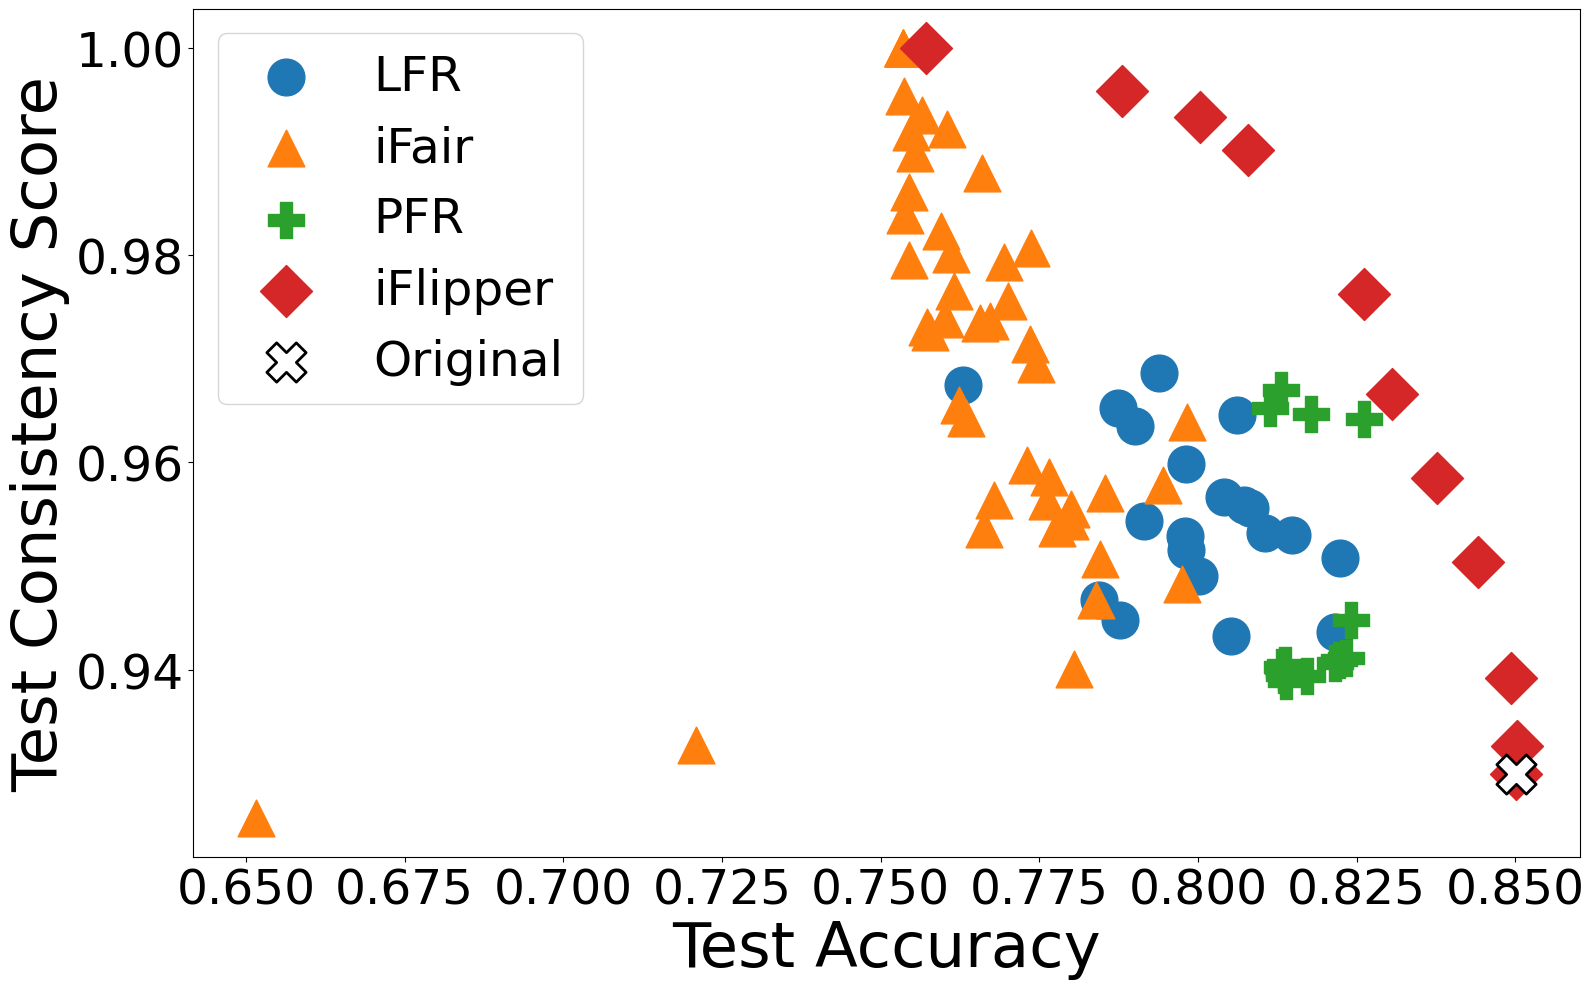

In [ ]:
from matplotlib.ticker import FormatStrFormatter

methods = ["LFR", "iFair", "PFR", "iFlipper", "Original"]
shapes = ["o", "^", "P", "D", "X"]
marker_size = 700

fig, ax = plt.subplots(figsize=(16, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

for i in range(len(methods)):
    if methods[i] == "Original":
        plt.scatter(test_accuracy[methods[i]], test_consistency_score[methods[i]], label=methods[i], s=marker_size+100, marker=shapes[i], edgecolors="black", linewidth=2, color="white")
    else:
        plt.scatter(test_accuracy[methods[i]], test_consistency_score[methods[i]], label=methods[i], s=marker_size, marker=shapes[i]) 
        
plt.tick_params(labelsize=35)
plt.xlabel("Test Accuracy", fontsize=45)
plt.ylabel("Test Consistency Score", fontsize=45)
plt.legend(prop={'size':35})

plt.tight_layout()
plt.show()